In this demo, we will explore the use of "skeleton" as a representation of a human pose to get human gait dynamics. A skeleton is a graphical structure connecting several pose landmarks, including nose, elbow, hip, knee, heel, etc. These pose landmarks detected on a sequence of ordered images enable us to extract gait dynamics over time, e.g., shoulder velocity, torso angle. We will use these gait dynamics to estimate a fall event.

In [1]:
!pip install -q gdown

In [17]:
!gdown --id 1xl_A5-VC0gM4ebMibR3CpIxsSjtbBbgP -O fall_scenario8_cam2.mp4

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xl_A5-VC0gM4ebMibR3CpIxsSjtbBbgP
To: /content/fall_scenario8_cam2.mp4
100% 2.00M/2.00M [00:00<00:00, 15.3MB/s]


We first download a video from the [multi-camera fall dataset](https://www.iro.umontreal.ca/~labimage/Dataset/?utm_source=chatgpt.com). The example used here is a simple scenario where a person walks into a room and then falls to the ground. Let's play the video to see what it looks like:

In [32]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("fall_scenario8_cam2.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=640 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

We create a class "FallDetector" accepting inputs of some thresholds including velocity of shoulders and torso angle. The human skeleton is extracted by a two-stage approach: _(i)_ detecting a person on an image through a lightweight and superfast MobileNetV3 CNN, and _(ii)_ landmark regression to predict 33 landmarks via a CNN regression. This process is hidden in the python package `mediapipe.mp_pose.Pose`.

The velocity of shoulders and the torso angle can be estimated by extracting the y-directional position of the landmark on the human body in the images. customized thresholds are used to decide if there is a fall event. Typically a fall happens when the shoulder velocity instantly becomes very fast, and the torso angle deviates from 0 degrees a lot.

In [14]:
!pip install mediapipe opencv-python numpy matplotlib scipy tqdm
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from IPython.display import Video, display
import os

class FallDetector:
    def __init__(self, vel_shoulder_thresh=3.0, torso_angle_thresh=60.0):
        """
        Args:
            vel_shoulder_thresh (float): Threshold for shoulder vertical velocity (px/frame)
            torso_angle_thresh (float): Threshold for torso inclination angle (degrees)
        """
        self.vel_thresh = vel_shoulder_thresh
        self.angle_thresh = torso_angle_thresh
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    def process_video(self, video_path, output_path="/content/pose_overlay.mp4", make_plots=True):
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

        prev_shoulder_y = None
        fall_detected = False
        frame_idx = 0

        vel_list, angle_list, frame_list = [], [], []

        # store fall event frames. Once a fall even is detected, the rest of the images belong to the same event.
        fall_frames = []

        # Loop over all the images in the video
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.pose.process(rgb)
            fall_status = "Normal"
            vel, angle = 0.0, 0.0

            if results.pose_landmarks:
                lm = results.pose_landmarks.landmark

                # extract shoulder and hip position in the y-direction
                shoulder_y = np.mean([
                    lm[self.mp_pose.PoseLandmark.LEFT_SHOULDER.value].y,
                    lm[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y
                ]) * h
                hip_y = np.mean([
                    lm[self.mp_pose.PoseLandmark.LEFT_HIP.value].y,
                    lm[self.mp_pose.PoseLandmark.RIGHT_HIP.value].y
                ]) * h

                # Shoulder vertical velocity
                if prev_shoulder_y is not None:
                    vel = abs(shoulder_y - prev_shoulder_y)
                prev_shoulder_y = shoulder_y

                # Torso inclination
                dy = shoulder_y - hip_y
                dx = np.mean([
                    lm[self.mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                    lm[self.mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x
                ]) * w - np.mean([
                    lm[self.mp_pose.PoseLandmark.LEFT_HIP.value].x,
                    lm[self.mp_pose.PoseLandmark.RIGHT_HIP.value].x
                ]) * w
                angle = np.degrees(np.arctan2(abs(dx), abs(dy)))

                # Heuristic fall detection
                if vel > self.vel_thresh and angle > self.angle_thresh:
                    fall_detected = True
                    fall_status = "FALL DETECTED"
                    fall_frames.append(frame_idx)
                elif fall_detected:
                    fall_status = "FALL DETECTED"
                    fall_frames.append(frame_idx)

                # Draw landmarks
                mp.solutions.drawing_utils.draw_landmarks(
                    frame, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp.solutions.drawing_styles.get_default_pose_landmarks_style())

                # Overlay info
                cv2.putText(frame, f"Vel: {vel:.1f}, Angle: {angle:.1f}", (20, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
                color = (0, 0, 255) if fall_status == "FALL DETECTED" else (0, 255, 0)
                cv2.putText(frame, fall_status, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

            # Store for plots
            frame_list.append(frame_idx)
            vel_list.append(vel)
            angle_list.append(angle)

            out.write(frame)
            frame_idx += 1

        cap.release()
        out.release()

        # Convert to browser-playable format silently
        fixed_path = os.path.splitext(output_path)[0] + "_fixed.mp4"
        !ffmpeg -y -loglevel error -i "{output_path}" -vcodec libx264 -acodec aac "{fixed_path}"
        # !ffmpeg -y -loglevel error -i "$output_path" -vcodec libx264 -acodec aac "$fixed_path"

        print(f"Processed video saved to {fixed_path}")
        if make_plots:
            self.plot_metrics(frame_list, vel_list, angle_list, fall_frames)

        return fixed_path

    def plot_metrics(self, frame_list, vel_list, angle_list, fall_frames):
        """Plot velocity and angle time series with fall event highlighted."""
        fig, ax1 = plt.subplots(figsize=(10,5))
        ax1.set_title("Gait & Fall Dynamics")
        ax1.set_xlabel("Frame index")
        ax1.set_ylabel("Shoulder vertical velocity (px/frame)", color='tab:blue')
        ax1.plot(frame_list, vel_list, label='Velocity', color='tab:blue')
        ax1.axhline(self.vel_thresh, color='tab:blue', linestyle='--', label='Vel threshold')

        ax2 = ax1.twinx()
        ax2.set_ylabel("Torso inclination angle (°)", color='tab:orange')
        ax2.plot(frame_list, angle_list, label='Torso angle', color='tab:orange')
        ax2.axhline(self.angle_thresh, color='tab:orange', linestyle='--', label='Angle threshold')

        # Highlight fall frames
        if fall_frames:
            start = fall_frames[0]
            prev = fall_frames[0]
            for f in fall_frames[1:] + [None]:  # add None to flush last segment
                if f is None or f != prev + 1:
                    ax1.axvspan(start, prev, color='red', alpha=0.1)
                    ax2.axvspan(start, prev, color='red', alpha=0.1)
                    start = f
                prev = f

        fig.legend(loc="upper right")
        plt.grid(True, linestyle=':')
        plt.show()




Let's run the fall detection on the video we downloaded earlier.

From the gait & fall dynamics, we observe a fall happens when there is a peak in shoulder velocity and a high torso angle that last for a long period of time. Starting from the fall event activation, the shaded area in the dunamics plot is the images labeled as a fall event.

In [18]:
!ls -lh /content


total 2.0M
-rw-r--r-- 1 root root 2.0M Oct 17 05:47 fall_scenario8_cam2.mp4
drwxr-xr-x 1 root root 4.0K Oct 16 13:41 sample_data


Processed video saved to /content/pose_overlay_fixed.mp4


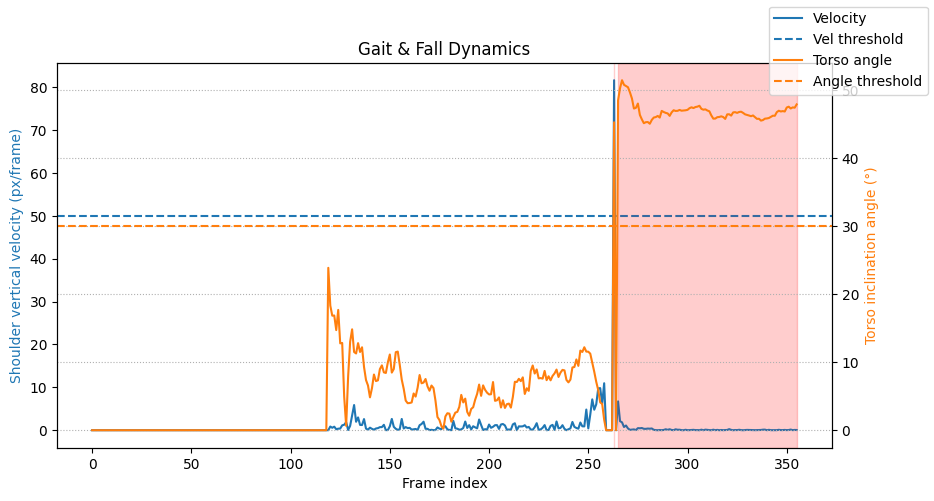

Checking file: /content/pose_overlay_fixed.mp4
Exists? True


In [19]:
# Provide your uploaded video path here
video_path = "/content/fall_scenario8_cam2.mp4"

# Initialize the fall detector with hyper-parameters
detector = FallDetector(vel_shoulder_thresh=50.0, torso_angle_thresh=30.0)
output_path = detector.process_video(video_path)

# Display the video and the gait dynamics over time
display(Video(output_path, embed=True))

The demo example shows a really simple scenraio. In practice, the situation is more complicated: there are actions such as sitting that could produce a false positive for the fall event, or the false positive in detecting a human skeleton (this happens when there are more furnitures present in the scene). There are thus several improvements we can make:

1. Sometimes a human skeleton can be extracted from a furniture. This is a false positive detection from the CNN regression. One possible solution is to integrate the above pipeline with the background subtraction approach to accurately isolate the human.   
2. The toso angle and the should velocity can be estimated differently from different perspectives of the camera capturing the scene. One solution is to to use multiple cameras to monitor the same room. This not only helps increase the fall detection accuracy, but also avoids the situation where furnitures block the human.
3. You may observe high frequency signinals in the gait dynamics plot. We may need to use signal denoising before adopting the estimated dynamics for fall detection.
4. The threshold-based approach is heuristic. A more robust approach is needed by using some modern deep learning approaches, but a lot of times the inference time cannot catch up with the camera frame rate.




